In [1]:
import numpy as np
import matplotlib.pyplot as plt
from FlowControl import add_to_class
from pandas import DataFrame,Series

In [2]:
from matplotlib import cm
from scipy.linalg import expm
from numpy.linalg import eig,svd

rng = lambda seed : np.random.default_rng(seed)

<h1>Dimensionality reduction</h1>

<h2>1. Principal component analysis</h2>

<h3>1.1 Theoretical introduction</h3>

Firstly, let us assume that all data is scaled according to standard scalling procedure:
$$
\bar{x}_{j}^{(i)} = \frac{x_{j}^{(i)} - \langle x_{j} \rangle}{\sigma_{j}}
$$

Let's suppose that we are given a dataset composed of points $\vec{x}^{(i)}\in \mathbb{R}^{d}$. It may happend, that our dataset in fact corresonds to the subspace of $\mathbb{R}^{d}$ or a manifold in this space. The goal of the PCA is to find the linear subspace of principal components. 

<h3>Method 1: SVD</h3>

SVD is a method of decomposition of a matrix $X$ into product of 3 matrices: $U\Sigma V^{T}$. It is particularly usefull if we want to reduce the dimension of the matrix. The interpretation of those matrices is the following:
- matrix $V$ is a unitary matrix composed of $d$ column vectors. It corresponds to the initial rotation. 
- matrix $\Sigma$ is a diagonal matrix for which each value corresponds to the particular scalling factor. After applying this matrix, we obtain contractions or dilatations allong basis axes.
- matrix $U$ is a unitary matrix which rotates to the final frame. 

In [3]:
X_mat = rng(42).uniform(size = 6).reshape(2,3)
X_mat = np.concatenate((X_mat,np.zeros(3)[np.newaxis,:]),axis = 0)

print(X_mat)

[[0.77395605 0.43887844 0.85859792]
 [0.69736803 0.09417735 0.97562235]
 [0.         0.         0.        ]]


In [4]:
def compute_after_trans(x,y,z,X_mat,phi_len,th_len):
    dpoints = np.vstack((x.flatten(),y.flatten(),z.flatten()))
    after = (X_mat @ dpoints).T
    return (after[:,i].reshape(phi_len,th_len) for i in range(3))

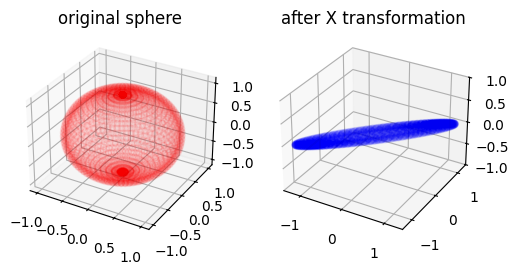

In [5]:
th_ = np.arange(0,np.pi,0.1)
phi_ = np.arange(0,2*np.pi,0.1)
th,phi = np.meshgrid(th_,phi_)

x = np.sin(th)*np.cos(phi)
y = np.sin(th)*np.sin(phi)
z = np.cos(th)

x_k,y_k,z_k = compute_after_trans(x,y,z,X_mat,len(phi_),len(th_))

fig = plt.figure(figsize = (6,3))
ax = fig.add_subplot(1,2,1,projection="3d")
ax1 = fig.add_subplot(1,2,2,projection="3d")

ax.scatter(x,y,z,color = "red",alpha = 0.05)
ax1.scatter(x_k,y_k,z_k,color = "blue",alpha = 0.05)
ax.set_title("original sphere")
ax1.set_title("after X transformation")
ax1.set_zlim(-1,1)

plt.show()


U shape: (3, 3), Sigma shape: (3,), V shape: (3, 3)


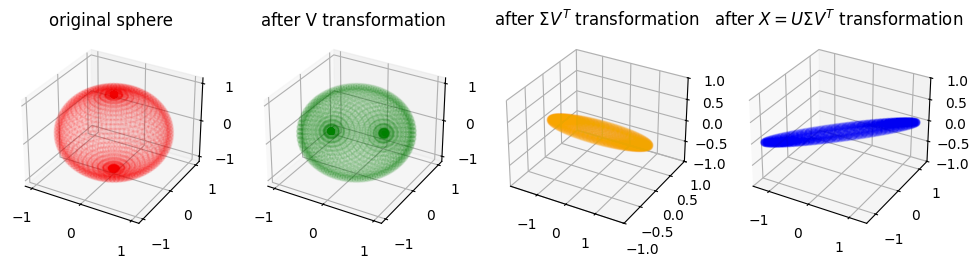

In [6]:
U,Si,V = svd(X_mat)
print(f"U shape: {U.shape}, Sigma shape: {Si.shape}, V shape: {V.shape}")

X1 = V
X2 = np.diag(Si) @ V
X3 = U @ np.diag(Si) @ V

x_1,y_1,z_1 = compute_after_trans(x,y,z,X1,len(phi_),len(th_))
x_2,y_2,z_2 = compute_after_trans(x,y,z,X2,len(phi_),len(th_))
x_3,y_3,z_3 = compute_after_trans(x,y,z,X3,len(phi_),len(th_))

fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot(1,4,1,projection="3d")
ax1 = fig.add_subplot(1,4,2,projection="3d")
ax2 = fig.add_subplot(1,4,3,projection="3d")
ax3 = fig.add_subplot(1,4,4,projection="3d")

ax.scatter(x,y,z,color = "red",alpha = 0.05)
ax1.scatter(x_1,y_1,z_1,color = "green",alpha = 0.05)
ax2.scatter(x_2,y_2,z_2,color = "orange",alpha = 0.05)
ax3.scatter(x_3,y_3,z_3,color = "blue",alpha = 0.05)
ax.set_title("original sphere")
ax1.set_title("after V transformation")
ax2.set_title("after "+r"$\Sigma V^{T}$"+" transformation")
ax3.set_title("after "+r"$X = U \Sigma V^{T}$"+" transformation")
ax2.set_ylim(-1,1)
ax2.set_zlim(-1,1)
ax3.set_zlim(-1,1)
plt.show()

Reduced dataset is generated by taking the following product:
$$
\hat{X}_{new} = \hat{X} V_{k-principal} 
$$
where $V_{k-principal}$ is a matrix composed of $k$ vectors from $V$ which correspond to $k$ principal values of $\Sigma$

<h3>Method 2: eigendecomposition of tensor product</h3>

Assuming that our data have been scaled previously, we can formulate another algorithm for PCA. Standard deviation along chosen axis $\vec{u}$ in feature space is given by: 
$$
\sigma_{u} = \frac{1}{n}\sum_{i=1}^{n}(\vec{u}\cdot \vec{x}^{(i)})^{2} = \frac{1}{n}\sum_{i=1}^{n}\sum_{k,j=1}^{d}u_{j}u_{k}x_{k}^{(i)}x_{j}^{(i)} = \vec{u}^{T} \frac{1}{n}\sum_{i=1}^{n}\vec{x}^{(i)}\otimes (\vec{x}^{(i)})^{T}\vec{u}
$$
so that the goal is to find the normalized $\vec{u}$ such that, it maximize $\sigma_{u}$ . It is straightforward that the $\vec{u}$ is the eigenvector of $P = \frac{1}{n}\sum_{i=1}^{n}\vec{x}^{(i)}\otimes (\vec{x}^{(i)})^{T}$ matrix corresponding to the maximal eigenvalue.

<h3>1.2 Implementation</h3>

In [7]:
class PCA:
    def __init__(self):
        pass

    def fit(self,X_data,k_princ = 2,method = "svd"):
        n,_ = X_data.shape
        X_data_t = self.prepare(X_data)
        if method == "svd":
            _,s,Vh = svd(X_data_t)
            inds = np.argsort(s)[::-1][:k_princ]
            self.V_ = Vh[inds,:].T
        elif method == "eigen":
            X_mat = sum(np.kron(X_data[i].reshape(-1,1),X_data[i]) for i in range(n)) / n
            E,U = eig(X_mat)
            inds = np.argsort(E)[::-1][:k_princ]
            self.V_ = U[inds,:].T
        else:
            raise NotImplementedError
        return (X_data_t @ self.V_ )
        
    def transform(self,X_data):
        assert hasattr(self,"V_"), "no parameters fitted yet"
        X_sta_tr = (X_data - self.means) / self.stds
        return X_sta_tr @ self.V_
        
    def prepare(self,X_data):
        assert len(X_data.shape) == 2, "invalid data shape"
        means = np.mean(X_data,axis = 0)
        std = np.std(X_data,axis = 0)
        self.means = means
        self.stds = std 
        return (X_data - means) / std


<h3>1.3 testing model on Iris data set</h3>

In [8]:
Rz = lambda th : np.real(expm(- 1j * np.array([
    [1,0,0],
    [0,0,0],
    [0,0,-1]
]) * th))

Ry = lambda th : np.real(expm(- 1j * np.array([
    [0,-1,0],
    [1,0,-1],
    [0,1,0]
]) * th))

In [9]:
from sklearn.datasets import load_iris

data_Set = load_iris()

X_p = data_Set["data"][:,[0,1]]
Rot = (Rz(np.pi/5) @ Ry(np.pi/3) @ Rz(np.pi/3))
X_data_3d = np.concatenate((X_p,rng(42).normal(loc = 0.,scale = 1,size = len(X_p)).reshape(-1,1)),axis = 1)
X_data = (Rot @ X_data_3d.T).T
y_data = data_Set["target"]

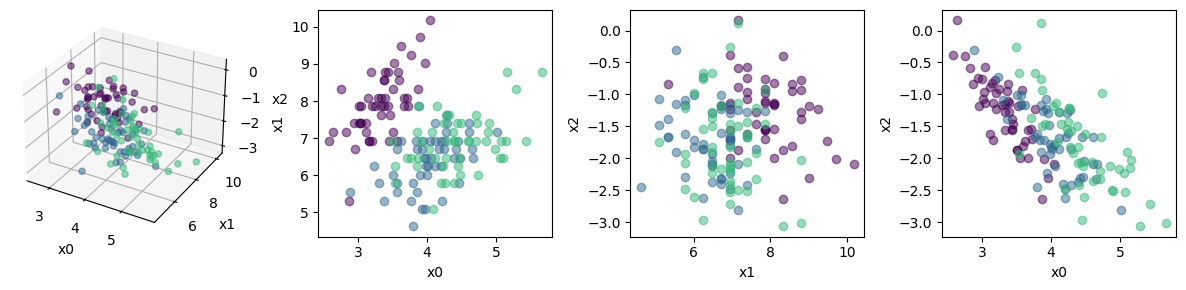

In [10]:
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot(1,4,1,projection = '3d')
ax1 = fig.add_subplot(1,4,2)
ax2 = fig.add_subplot(1,4,3)
ax3 = fig.add_subplot(1,4,4)

classes = np.unique(y_data)
colors = [cm.viridis(i / len(classes)) for i in range(len(classes))]
for i in range(len(classes)):
    inds = y_data == classes[i]
    ax.scatter(X_data[inds,0],X_data[inds,1],X_data[inds,2],color = colors[i],alpha = 0.5)
    ax1.scatter(X_data[inds,0],X_data[inds,1],color = colors[i],alpha = 0.5)
    ax2.scatter(X_data[inds,1],X_data[inds,2],color = colors[i],alpha = 0.5)
    ax3.scatter(X_data[inds,0],X_data[inds,2],color = colors[i],alpha = 0.5)

ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("x2")

ax1.set_xlabel("x0")
ax1.set_ylabel("x1")

ax2.set_xlabel("x1")
ax2.set_ylabel("x2")

ax3.set_xlabel("x0")
ax3.set_ylabel("x2")

plt.tight_layout()
plt.show()


In [11]:
pca = PCA()
X_trans_svd = pca.fit(X_data,method = "svd")
X_trans_eig = pca.fit(X_data,method = "eigen")

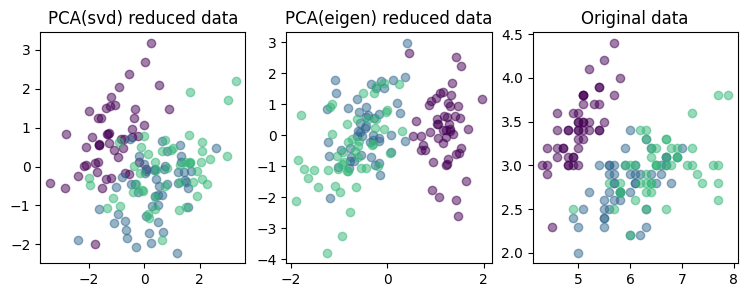

In [12]:
fig = plt.figure(figsize = (9,3))
ax = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)

classes = np.unique(y_data)
colors = [cm.viridis(i / len(classes)) for i in range(len(classes))]
for i in range(len(classes)):
    inds = y_data == classes[i]
    ax.scatter(X_trans_svd[inds,0],X_trans_svd[inds,1],color = colors[i],alpha = 0.5)
    ax1.scatter(X_trans_eig[inds,1],X_trans_eig[inds,0],color = colors[i],alpha = 0.5)
    ax2.scatter(X_p[inds,0],X_p[inds,1],color = colors[i],alpha = 0.5)
ax.set_title("PCA(svd) reduced data")
ax1.set_title("PCA(eigen) reduced data")
ax2.set_title("Original data")


plt.show()

<h2>2. Simple usecase<h2>

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,random_state=32,train_size=0.7)

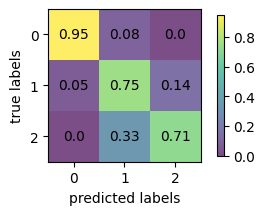

In [15]:
model1 = LogisticRegression()
model1.fit(X_train,y_train)
y_pred1 = model1.predict(X_test)

cm = confusion_matrix(y_test,y_pred1)
cm = cm / np.sum(cm,axis = 1)

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot()
im = ax.imshow(cm,cmap = "viridis",alpha = 0.7)
n,m = cm.shape
for i in range(n):
    for j in range(m):
        ax.text(j,i,np.round(cm[i,j],2),color = "black",ha = "center",va = "center")
ax.set_xlabel("predicted labels")
ax.set_ylabel("true labels")

fig.colorbar(im,ax = ax, fraction=0.04, pad=0.09)
plt.tight_layout()
plt.show()

In [16]:
pca_lr_svd = PCA()
X_train_svd = pca_lr_svd.fit(X_train,method = "svd")
model_svd = LogisticRegression()
model_svd.fit(X_train_svd,y_train)
y_pred_svd = model_svd.predict(pca_lr_svd.transform(X_test))

pca_lr_eig = PCA()
X_train_eig = pca_lr_eig.fit(X_train,method = "eigen")
model_eig = LogisticRegression()
model_eig.fit(X_train_eig,y_train)
y_pred_eig = model_eig.predict(pca_lr_eig.transform(X_test))

y_preds = [y_pred1,y_pred_svd,y_pred_eig]
labels = ["original data","PCA with svd", "PCA with eigen"]

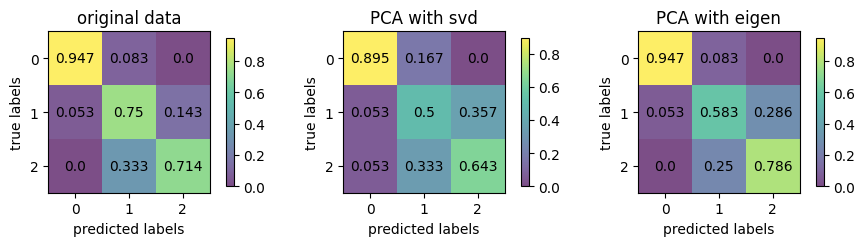

In [17]:
fig = plt.figure(figsize = (9,3))
for k in range(3):
    ax = fig.add_subplot(1,3,k+1)
    cm = confusion_matrix(y_test,y_preds[k])
    cm = cm / (np.sum(cm,axis = 1)[np.newaxis,:])
    im = ax.imshow(cm,cmap = "viridis",alpha = 0.7)
    n,m = cm.shape
    for i in range(n):
        for j in range(m):
            ax.text(j,i,np.round(cm[i,j],3),color = "black",ha = "center",va = "center")
    ax.set_xlabel("predicted labels")
    ax.set_ylabel("true labels")
    ax.set_title(labels[k])
    fig.colorbar(im,ax = ax, fraction=0.04, pad=0.09)
plt.tight_layout()
plt.show()

It is clear, that we lost information by projecting onto features subspace, therefore the original model can is better than the transformed one. PCA method should be used only if we have multidimensional features, and we want to extract the essental information for the dataset but we have to pay the cost of lose of information.